# Better comparison notebook

Because the other one is very dirty.

# Dependencies

In [36]:
library(viridis)
library(ggplot2)
library(plotly)
library(dplyr)
library(tidyr)
library(tikzDevice)
library(gridExtra)
library(zoo)
library(ggpointdensity)
library(hexbin)

getwd()
# modify default plots size
options(repr.plot.width=15, repr.plot.height=7)
#setwd("yourpathifnecessary")

[1] "/home/clem/Code/github.com/klementc/calvin-microbenchmarks/comparison"

# Launch experiment templates

## Real-World
Build docker container (uid to have write permissions on log output):
```
docker build --build-arg UID=$(id -u) --build-arg GID=$(id -g) -f bb.dockerfile -t testimg .
```

Modify suffix, logdir and timestamp files according to your needs.

Launch one experiment alone:
```
docker run -d -v ~/logs_expe/goLogs:/logs --cpus=1.0 --cpuset-cpus=6 -e cpuload=100 --network host --rm -ti expe/rmqgo:latest /bin/bash -c "cd scripts ; N1COST=10000000 suffix=test logDir=/logs/test tsFile=../timestamps/tsCal.csv bash launchOnce.sh"
```

Launch a full calibration:
```
docker run -d -v ~/logs_expe/goLogs:/logs --cpus=1.0 --cpuset-cpus=6 -e cpuload=100 --network host --rm -ti expe/rmqgo:latest /bin/bash -c "cd scripts ; N1COST=10000000 suffix=test logDir=/logs/test tsFile=../timestamps/tsCal.csv start=1000000 end=100000000 iter=5000000 nbSamples=3 bash launchCalib.sh"
```

## SG

Here the int values are flops, not loop iterations
```
logDir=~/logs_expe/sgLogs/test start=10000000 end=100000000 incr=10000000  bash launch.sh
```

# Calibration

## Real World results (on laptop)

Original command:
```
docker run -d -v ~/logs_expe/goLogs:/logs --cpus=1.0 --cpuset-cpus=6 -e cpuload=100 --network host --rm -ti expe/rmqgo:latest /bin/bash -c "cd scripts ; N1COST=10000000 suffix=test logDir=/logs/testCalib tsFile=../timestamps/tsCal.csv start=1000000 end=100000000 iter=5000000 nbSamples=3 bash launchCalib.sh"
```

 serviceName            nbIter           timestamp          totDurInServ     
 Length:5945        Min.   : 1000000   Min.   :0.000e+00   Min.   :  488587  
 Class :character   1st Qu.:21000000   1st Qu.:7.202e+10   1st Qu.:21025561  
 Mode  :character   Median :46000000   Median :1.470e+11   Median :38430084  
                    Mean   :48461733   Mean   :1.472e+11   Mean   :38658788  
                    3rd Qu.:71000000   3rd Qu.:2.220e+11   3rd Qu.:55395821  
                    Max.   :96000000   Max.   :2.971e+11   Max.   :91342557  
   computeDur          parExec       totReqProcessed  timestampSec   
 Min.   :  486103   Min.   :0.0000   Min.   : 0.00   Min.   :  0.00  
 1st Qu.:21004900   1st Qu.:1.0000   1st Qu.:24.00   1st Qu.: 72.02  
 Median :38422336   Median :1.0000   Median :49.00   Median :147.03  
 Mean   :38649859   Mean   :0.8335   Mean   :49.04   Mean   :147.16  
 3rd Qu.:55388252   3rd Qu.:1.0000   3rd Qu.:74.00   3rd Qu.:222.04  
 Max.   :91332211   Max.   :1.0000

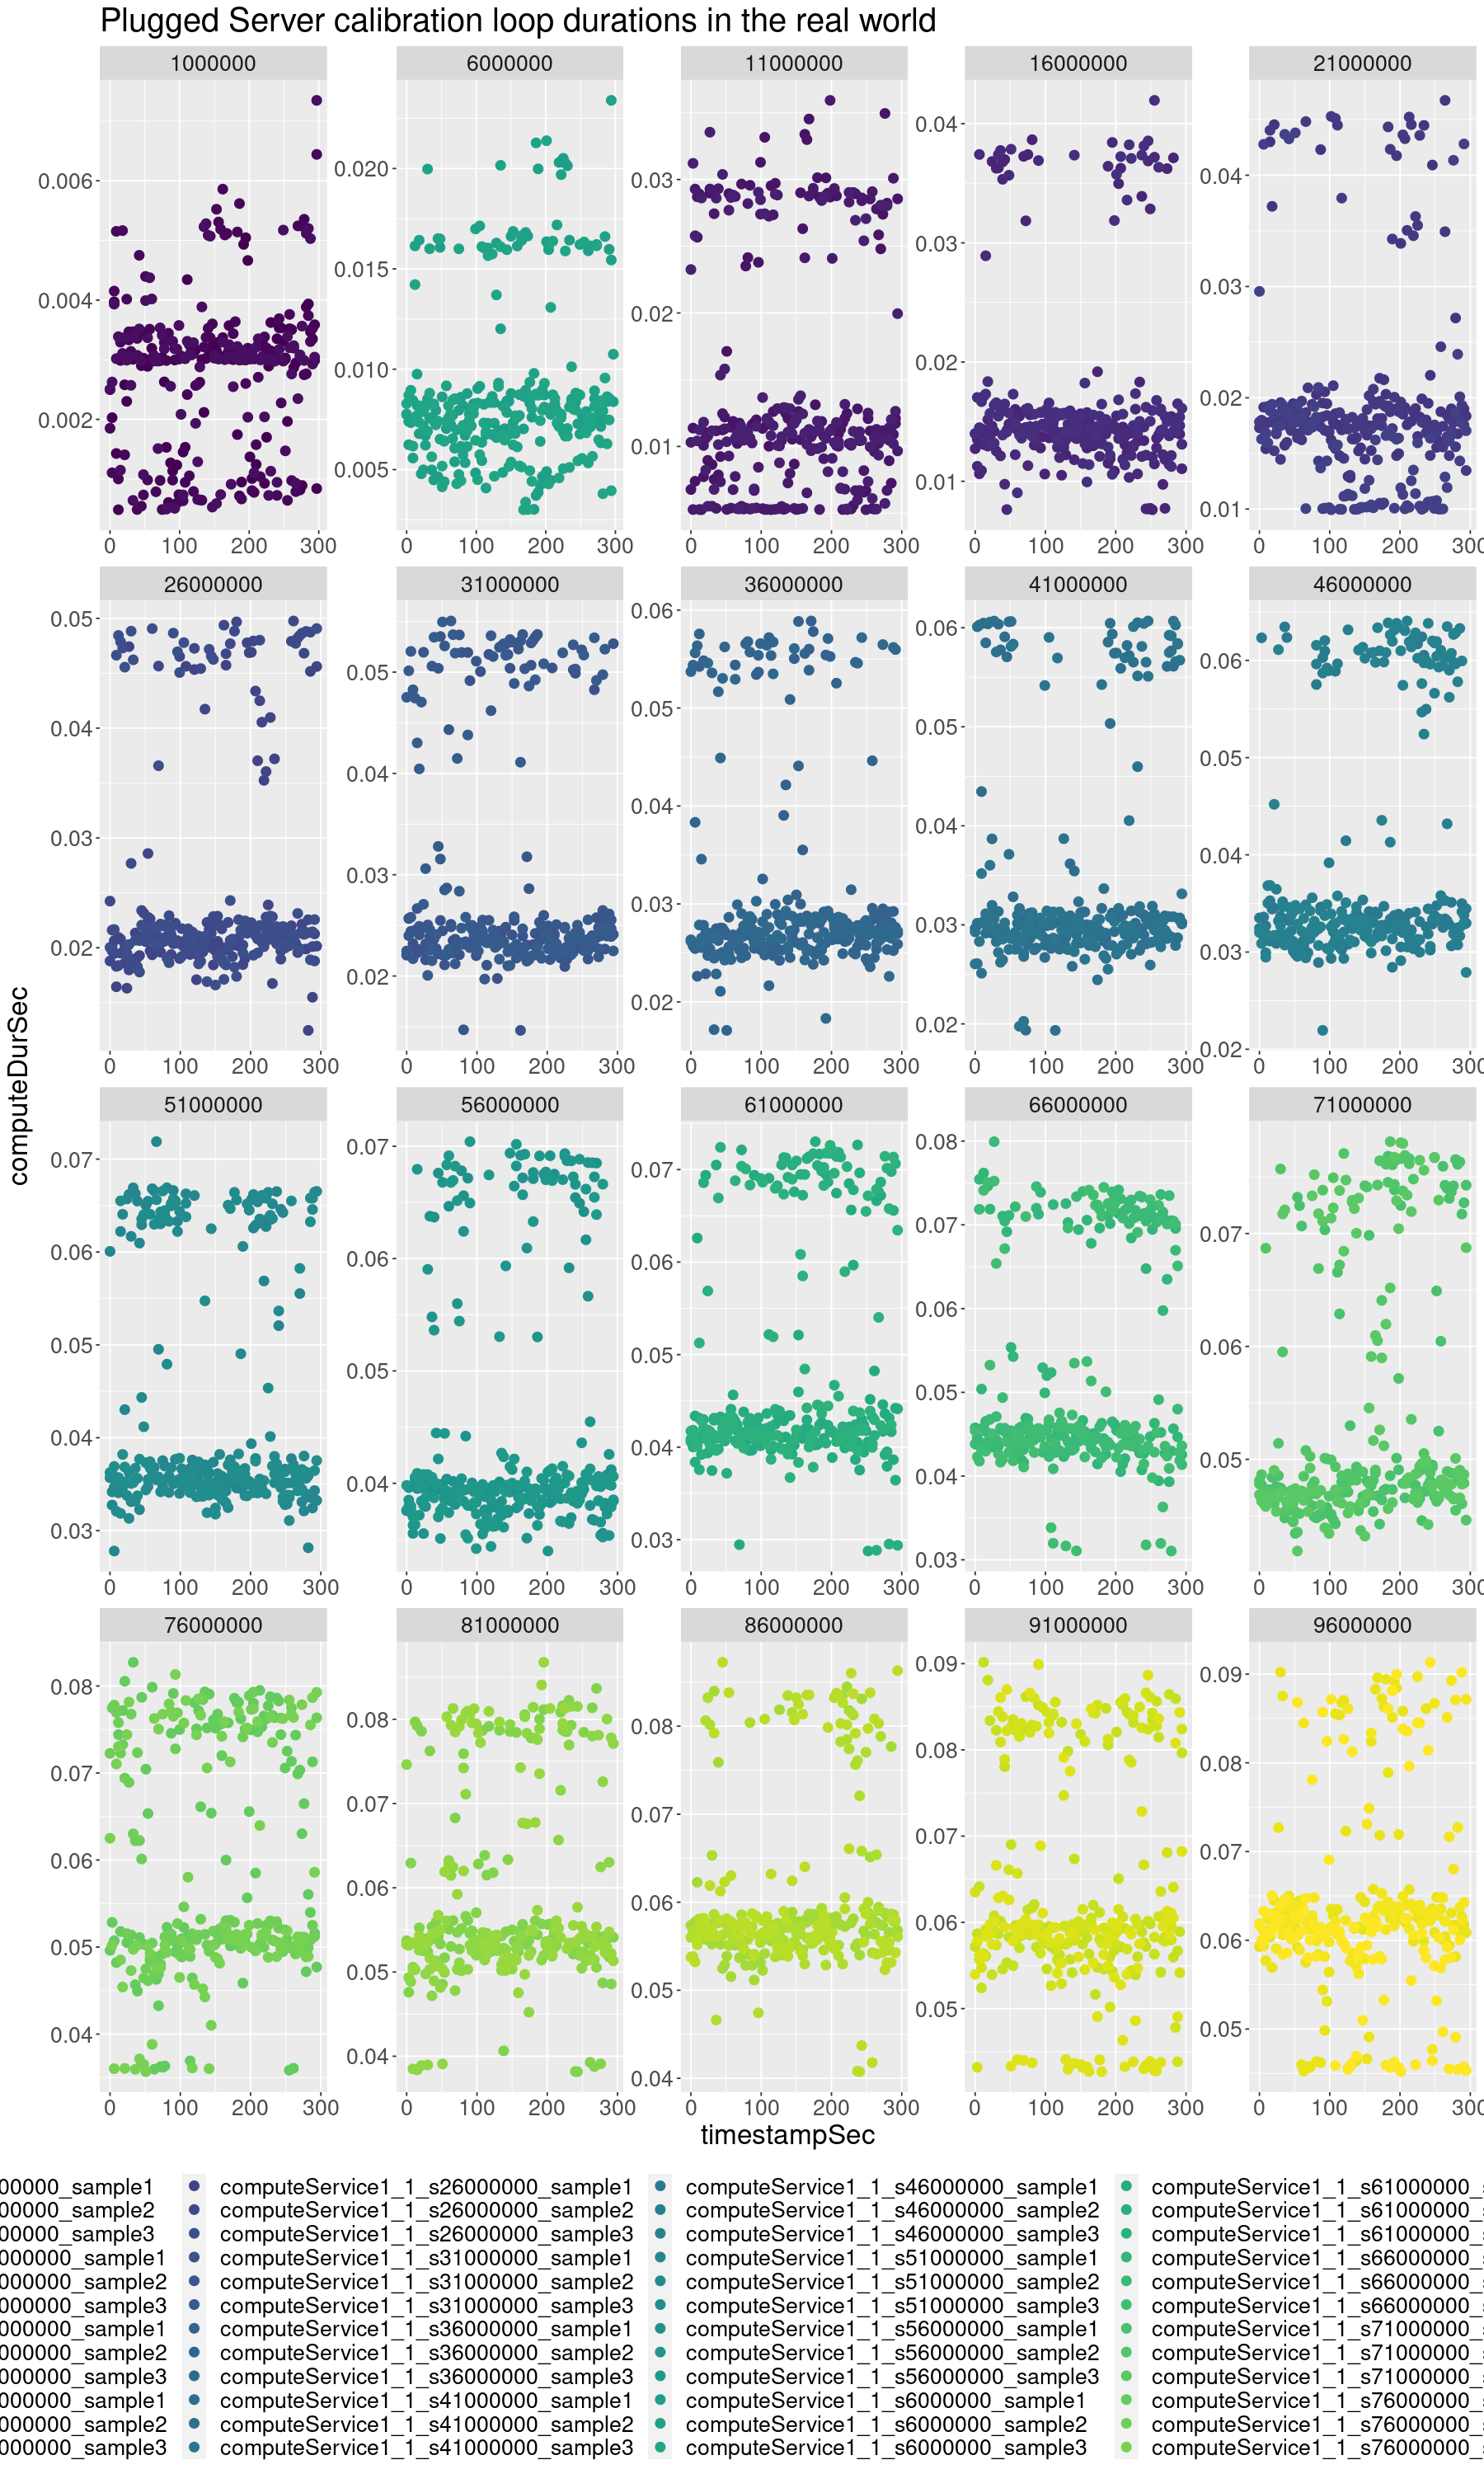

In [40]:
options(repr.plot.width=15, repr.plot.height=25)

data_RW_cal <- as_tibble(read.csv("~/logs_expe/goLogs/testCalib/aggrResults_1000000-5000000-100000000_3.csv"))
data_RW_cal$timestampSec <- as.numeric(as.character(data_RW_cal$timestamp)) / 1e9
data_RW_cal$computeDurSec <- as.numeric(as.character(data_RW_cal$computeDur)) / 1e9
#head(data_loadRW_unplugged_953)
summary(data_RW_cal)
#my_dataRW_1_compute <- my_dataRW_1 %>% filter(service == "compute")

ggplot(data_RW_cal, aes(x=timestampSec, y=computeDurSec, colour=serviceName))+
    geom_point(size=3)+
    #geom_line(color="blue")+
    #geom_line(aes(y=rollmean(execDur, 50, na.pad=TRUE)), color="green", size=1.5)+
    ggtitle("Plugged Server calibration loop durations in the real world")+
    facet_wrap("nbIter", scales="free")+
    theme( legend.position="bottom", text = element_text(size = 20)) + 
  scale_color_viridis(discrete = TRUE, option = "D")+
  scale_fill_viridis(discrete = TRUE) 

## on G5K

 serviceName            nbIter           timestamp          totDurInServ     
 Length:1900        Min.   : 1000000   Min.   :0.000e+00   Min.   :  378861  
 Class :character   1st Qu.: 6000000   1st Qu.:7.426e+10   1st Qu.: 2292995  
 Mode  :character   Median :16000000   Median :1.485e+11   Median : 5721894  
                    Mean   :14421053   Mean   :1.485e+11   Mean   : 5292225  
                    3rd Qu.:21000000   3rd Qu.:2.228e+11   3rd Qu.: 7611749  
                    Max.   :31000000   Max.   :2.970e+11   Max.   :16837056  
   computeDur          parExec         totReqProcessed  timestampSec   
 Min.   :  374203   Min.   :0.000000   Min.   : 0.00   Min.   :  0.00  
 1st Qu.: 2290406   1st Qu.:0.000000   1st Qu.:24.75   1st Qu.: 74.26  
 Median : 5719372   Median :0.000000   Median :49.50   Median :148.51  
 Mean   : 5289089   Mean   :0.003158   Mean   :49.50   Mean   :148.51  
 3rd Qu.: 7607225   3rd Qu.:0.000000   3rd Qu.:74.25   3rd Qu.:222.77  
 Max.   :16832499   Ma

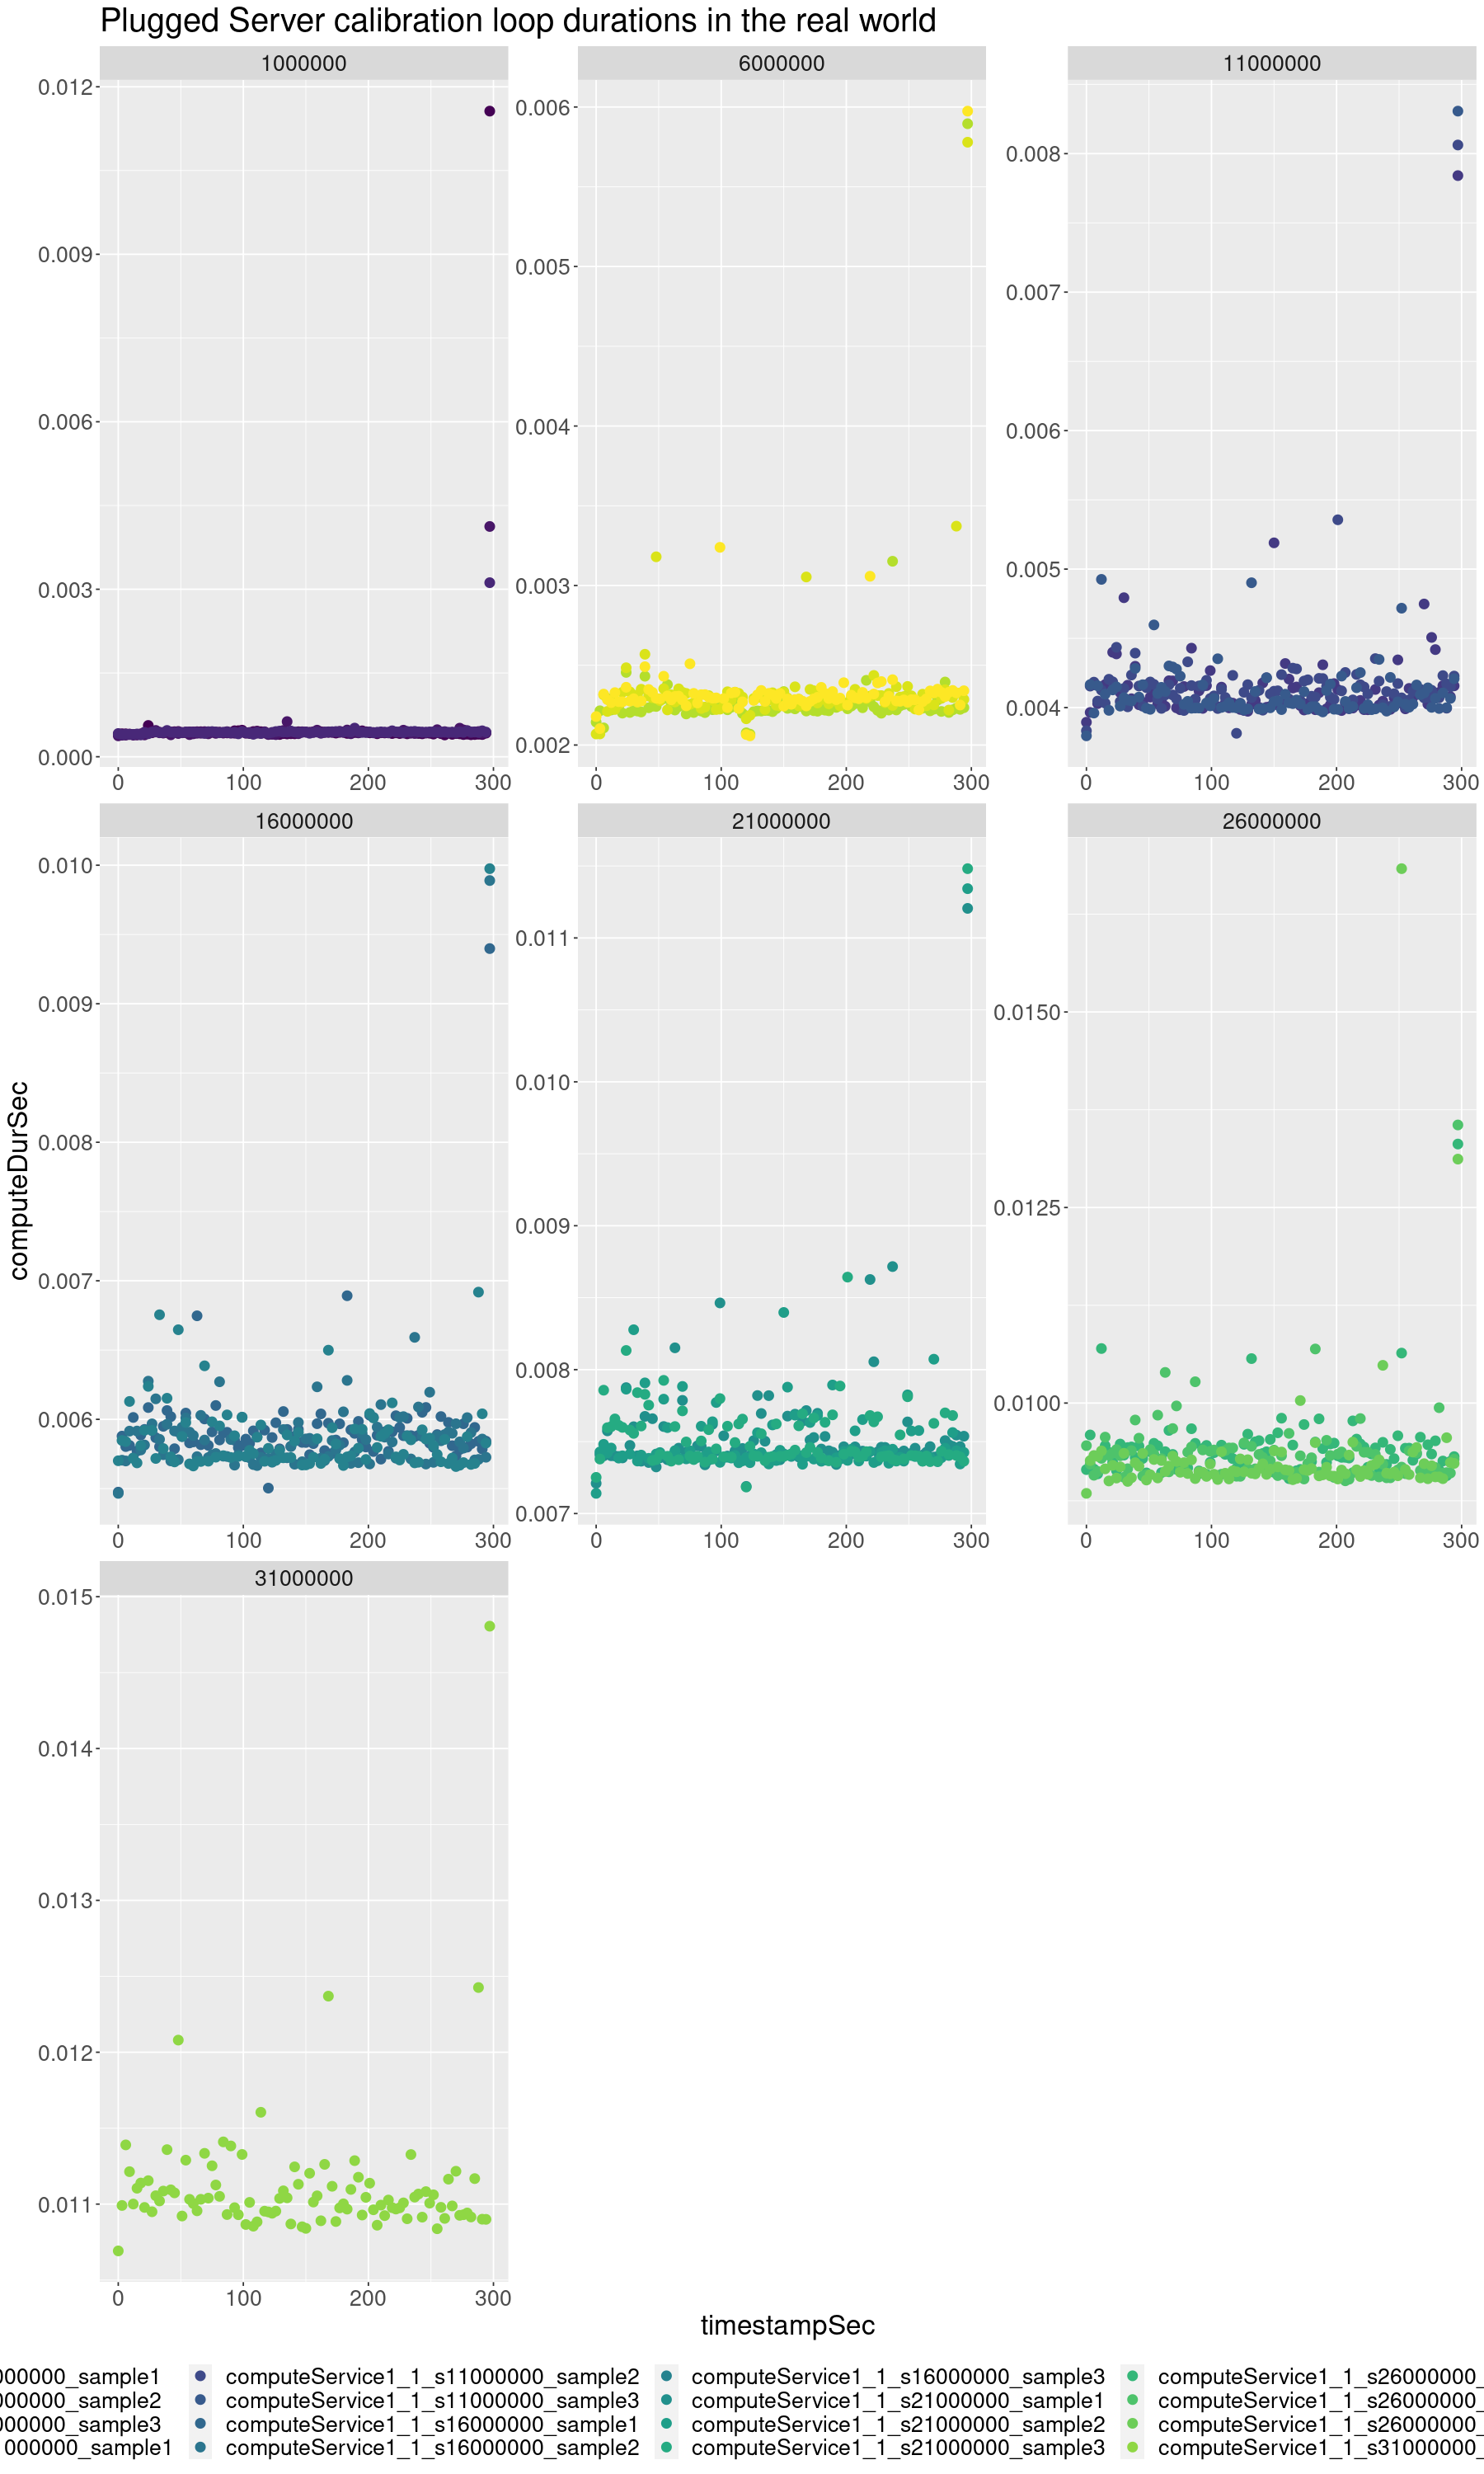

In [65]:
options(repr.plot.width=15, repr.plot.height=25)

data_RW_cal_G5K <- as_tibble(read.csv("~/logs_expe/goLogs/g5klogs/g5kcal/aggrResults_1000000-5000000-100000000_3.csv"))
data_RW_cal_G5K$timestampSec <- as.numeric(as.character(data_RW_cal_G5K$timestamp)) / 1e9
data_RW_cal_G5K$computeDurSec <- as.numeric(as.character(data_RW_cal_G5K$computeDur)) / 1e9
#head(data_loadRW_unplugged_953)
summary(data_RW_cal)
#my_dataRW_1_compute <- my_dataRW_1 %>% filter(service == "compute")

ggplot(data_RW_cal_G5K, aes(x=timestampSec, y=computeDurSec, colour=serviceName))+
    geom_point(size=3)+
    #geom_line(color="blue")+
    #geom_line(aes(y=rollmean(execDur, 50, na.pad=TRUE)), color="green", size=1.5)+
    ggtitle("Plugged Server calibration loop durations in the real world")+
    facet_wrap("nbIter", scales="free")+
    theme( legend.position="bottom", text = element_text(size = 20)) + 
  scale_color_viridis(discrete = TRUE, option = "D")+
  scale_fill_viridis(discrete = TRUE) 

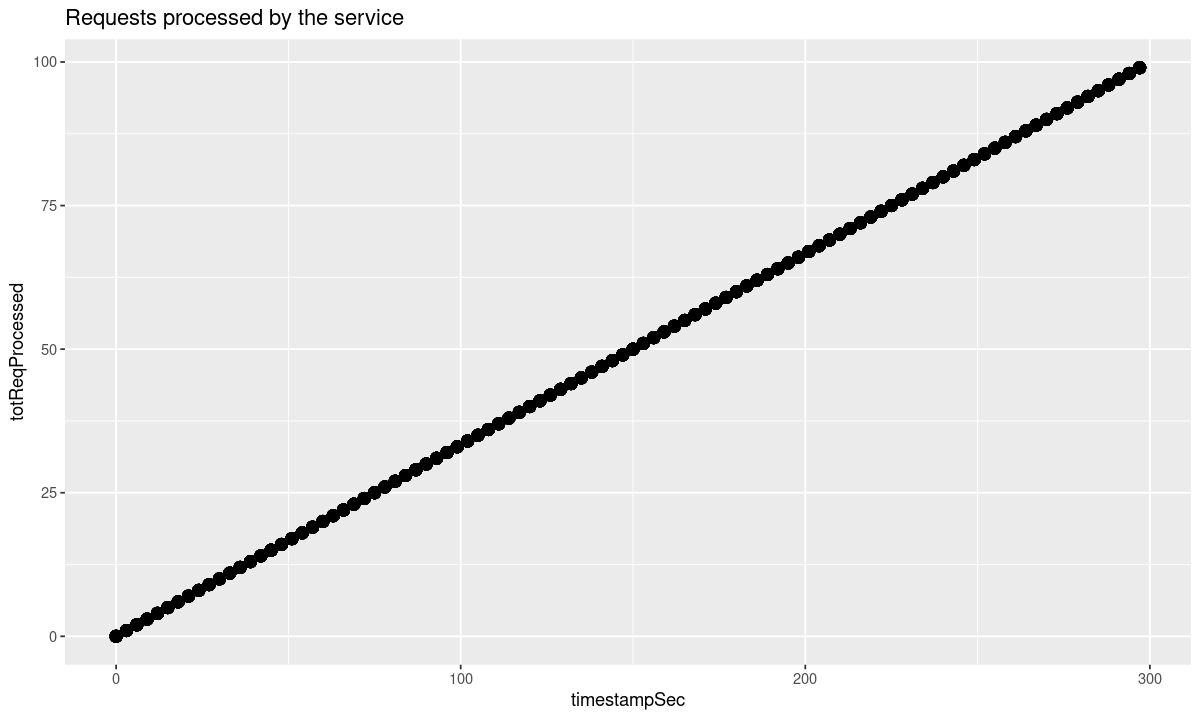

In [70]:
options(repr.plot.width=10, repr.plot.height=6)


ggplot(data_RW_cal_G5K, aes(x=timestampSec, y=totReqProcessed))+
    ggtitle("Requests processed by the service")+
    geom_point(size=3)


In [ ]:
options(repr.plot.width=15, repr.plot.height=5)

data_RW_cal_G5K <- as_tibble(read.csv("~/logs_expe/goLogs/g5klogs/g5kcal/aggrResults_1000000-5000000-100000000_3.csv"))
data_RW_cal_G5K$timestampSec <- as.numeric(as.character(data_RW_cal_G5K$timestamp)) / 1e9
data_RW_cal_G5K$computeDurSec <- as.numeric(as.character(data_RW_cal_G5K$computeDur)) / 1e9
#head(data_loadRW_unplugged_953)
summary(data_RW_cal)
#my_dataRW_1_compute <- my_dataRW_1 %>% filter(service == "compute")

ggplot(data_RW_cal_G5K, aes(x=timestampSec, y=computeDurSec, colour=serviceName))+
    geom_point(size=3)+
    #geom_line(color="blue")+
    #geom_line(aes(y=rollmean(execDur, 50, na.pad=TRUE)), color="green", size=1.5)+
    ggtitle("Plugged Server calibration loop durations in the real world")+
    facet_wrap("nbIter", scales="free")+
    theme( legend.position="bottom", text = element_text(size = 20)) + 
  scale_color_viridis(discrete = TRUE, option = "D")+
  scale_fill_viridis(discrete = TRUE) 

# Run with realistic workload

## on laptop

 serviceName            nbIter           timestamp          totDurInServ      
 Length:60967       Min.   : 1000000   Min.   :0.000e+00   Min.   :   467528  
 Class :character   1st Qu.: 6000000   1st Qu.:1.181e+11   1st Qu.:  4021998  
 Mode  :character   Median :11000000   Median :1.680e+11   Median :  8606668  
                    Mean   :10285269   Mean   :1.729e+11   Mean   : 12696803  
                    3rd Qu.:16000000   3rd Qu.:2.601e+11   3rd Qu.: 15767293  
                    Max.   :21000000   Max.   :3.011e+11   Max.   :148771253  
   computeDur           parExec        totReqProcessed  timestampSec  
 Min.   :   466477   Min.   :-1.0000   Min.   :   0    Min.   :  0.0  
 1st Qu.:  4019816   1st Qu.: 0.0000   1st Qu.:1088    1st Qu.:118.1  
 Median :  8602740   Median : 0.0000   Median :2177    Median :168.0  
 Mean   : 12690797   Mean   : 0.3949   Mean   :2177    Mean   :172.9  
 3rd Qu.: 15760108   3rd Qu.: 1.0000   3rd Qu.:3265    3rd Qu.:260.1  
 Max.   :148767820   

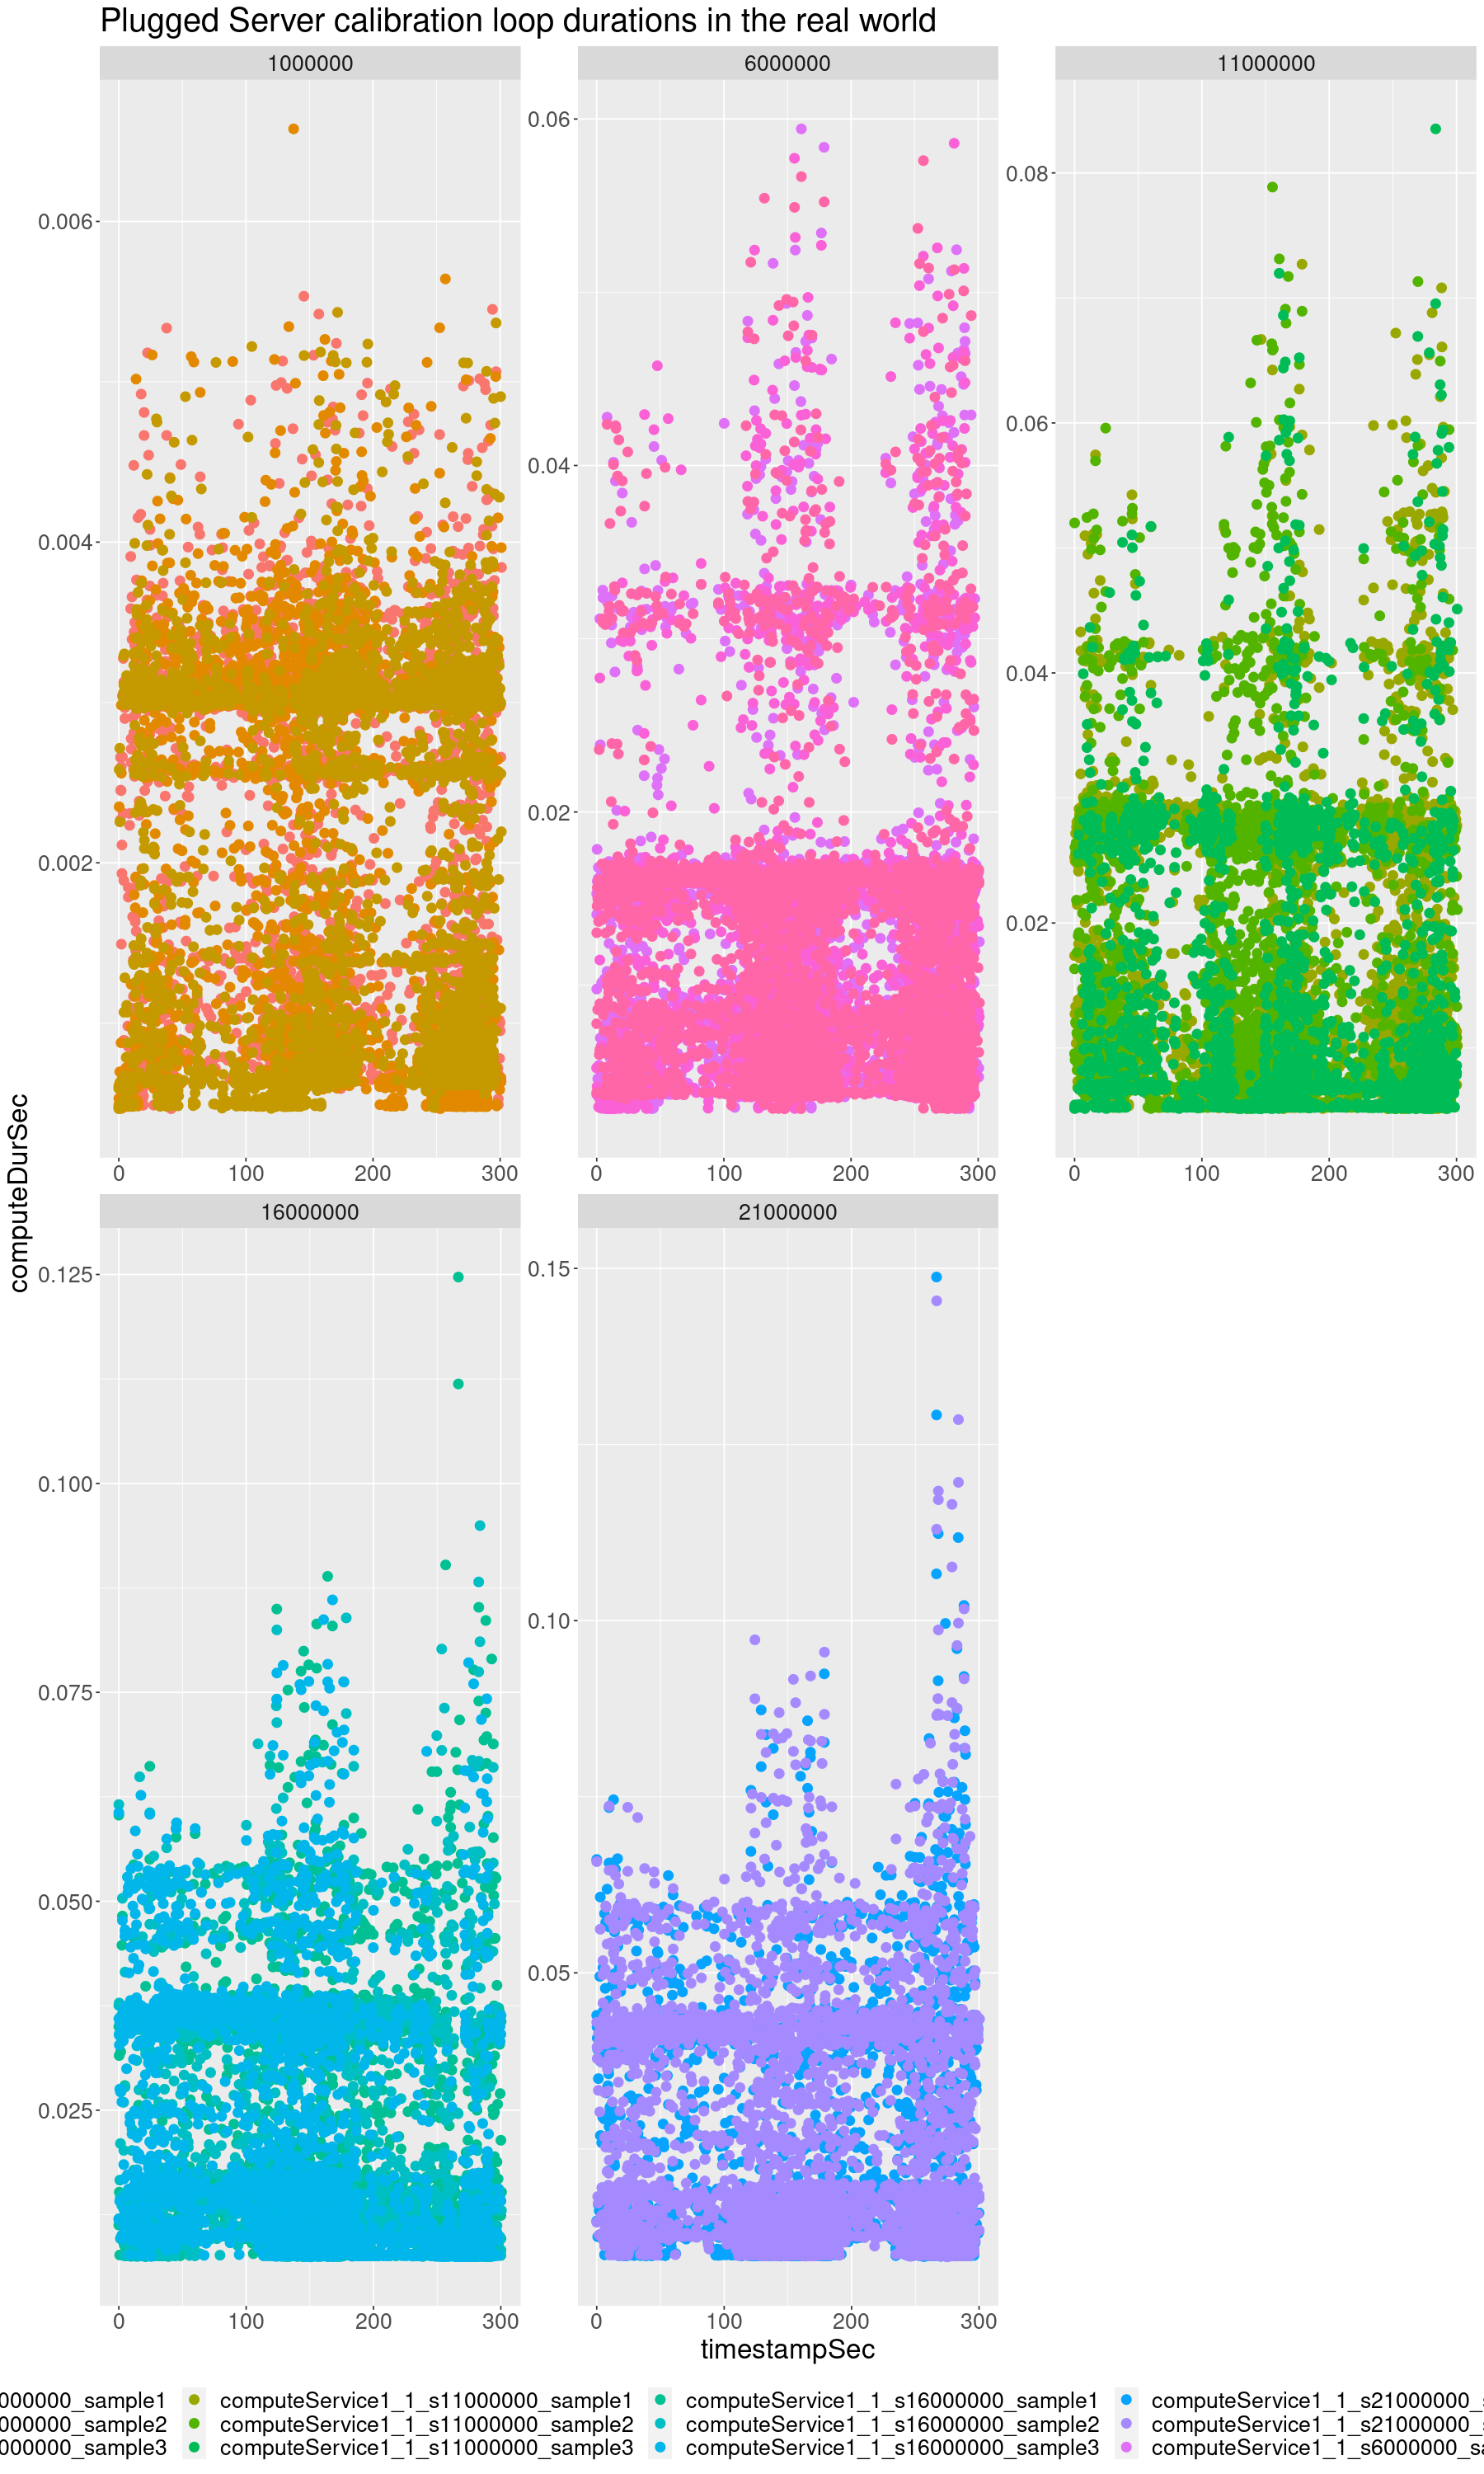

In [85]:
options(repr.plot.width=15, repr.plot.height=25)

data_RW_run <- as_tibble(read.csv("~/logs_expe/goLogs/testRun/aggrResults_1000000-5000000-100000000_3.csv"))
data_RW_run$timestampSec <- as.numeric(as.character(data_RW_run$timestamp)) / 1e9
data_RW_run$computeDurSec <- as.numeric(as.character(data_RW_run$computeDur)) / 1e9
#head(data_loadRW_unplugged_953)
summary(data_RW_run)
#my_dataRW_1_compute <- my_dataRW_1 %>% filter(service == "compute")

ggplot(data_RW_run, aes(x=timestampSec, y=computeDurSec, colour=serviceName))+
    geom_point(size=3)+
    #geom_line(color="blue")+
    #geom_line(aes(y=rollmean(execDur, 50, na.pad=TRUE)), color="green", size=1.5)+
    ggtitle("Plugged Server calibration loop durations in the real world")+
    facet_wrap("nbIter", scales="free")+
    theme( legend.position="bottom", text = element_text(size = 20)) 

## Real World


 serviceName            nbIter           timestamp          totDurInServ      
 Length:39195       Min.   : 1000000   Min.   :0.000e+00   Min.   :   374400  
 Class :character   1st Qu.:11000000   1st Qu.:1.179e+11   1st Qu.:  4010304  
 Mode  :character   Median :21000000   Median :1.677e+11   Median :  7455873  
                    Mean   :18777778   Mean   :1.727e+11   Mean   :  7321004  
                    3rd Qu.:31000000   3rd Qu.:2.598e+11   3rd Qu.: 11057334  
                    Max.   :41000000   Max.   :3.005e+11   Max.   :151130516  
   computeDur           parExec         totReqProcessed  timestampSec  
 Min.   :   372255   Min.   :-1.00000   Min.   :   0    Min.   :  0.0  
 1st Qu.:  4007676   1st Qu.: 0.00000   1st Qu.:1088    1st Qu.:117.9  
 Median :  7452684   Median : 0.00000   Median :2177    Median :167.7  
 Mean   :  7318162   Mean   : 0.09693   Mean   :2177    Mean   :172.7  
 3rd Qu.: 11054706   3rd Qu.: 0.00000   3rd Qu.:3266    3rd Qu.:259.8  
 Max.   :151126

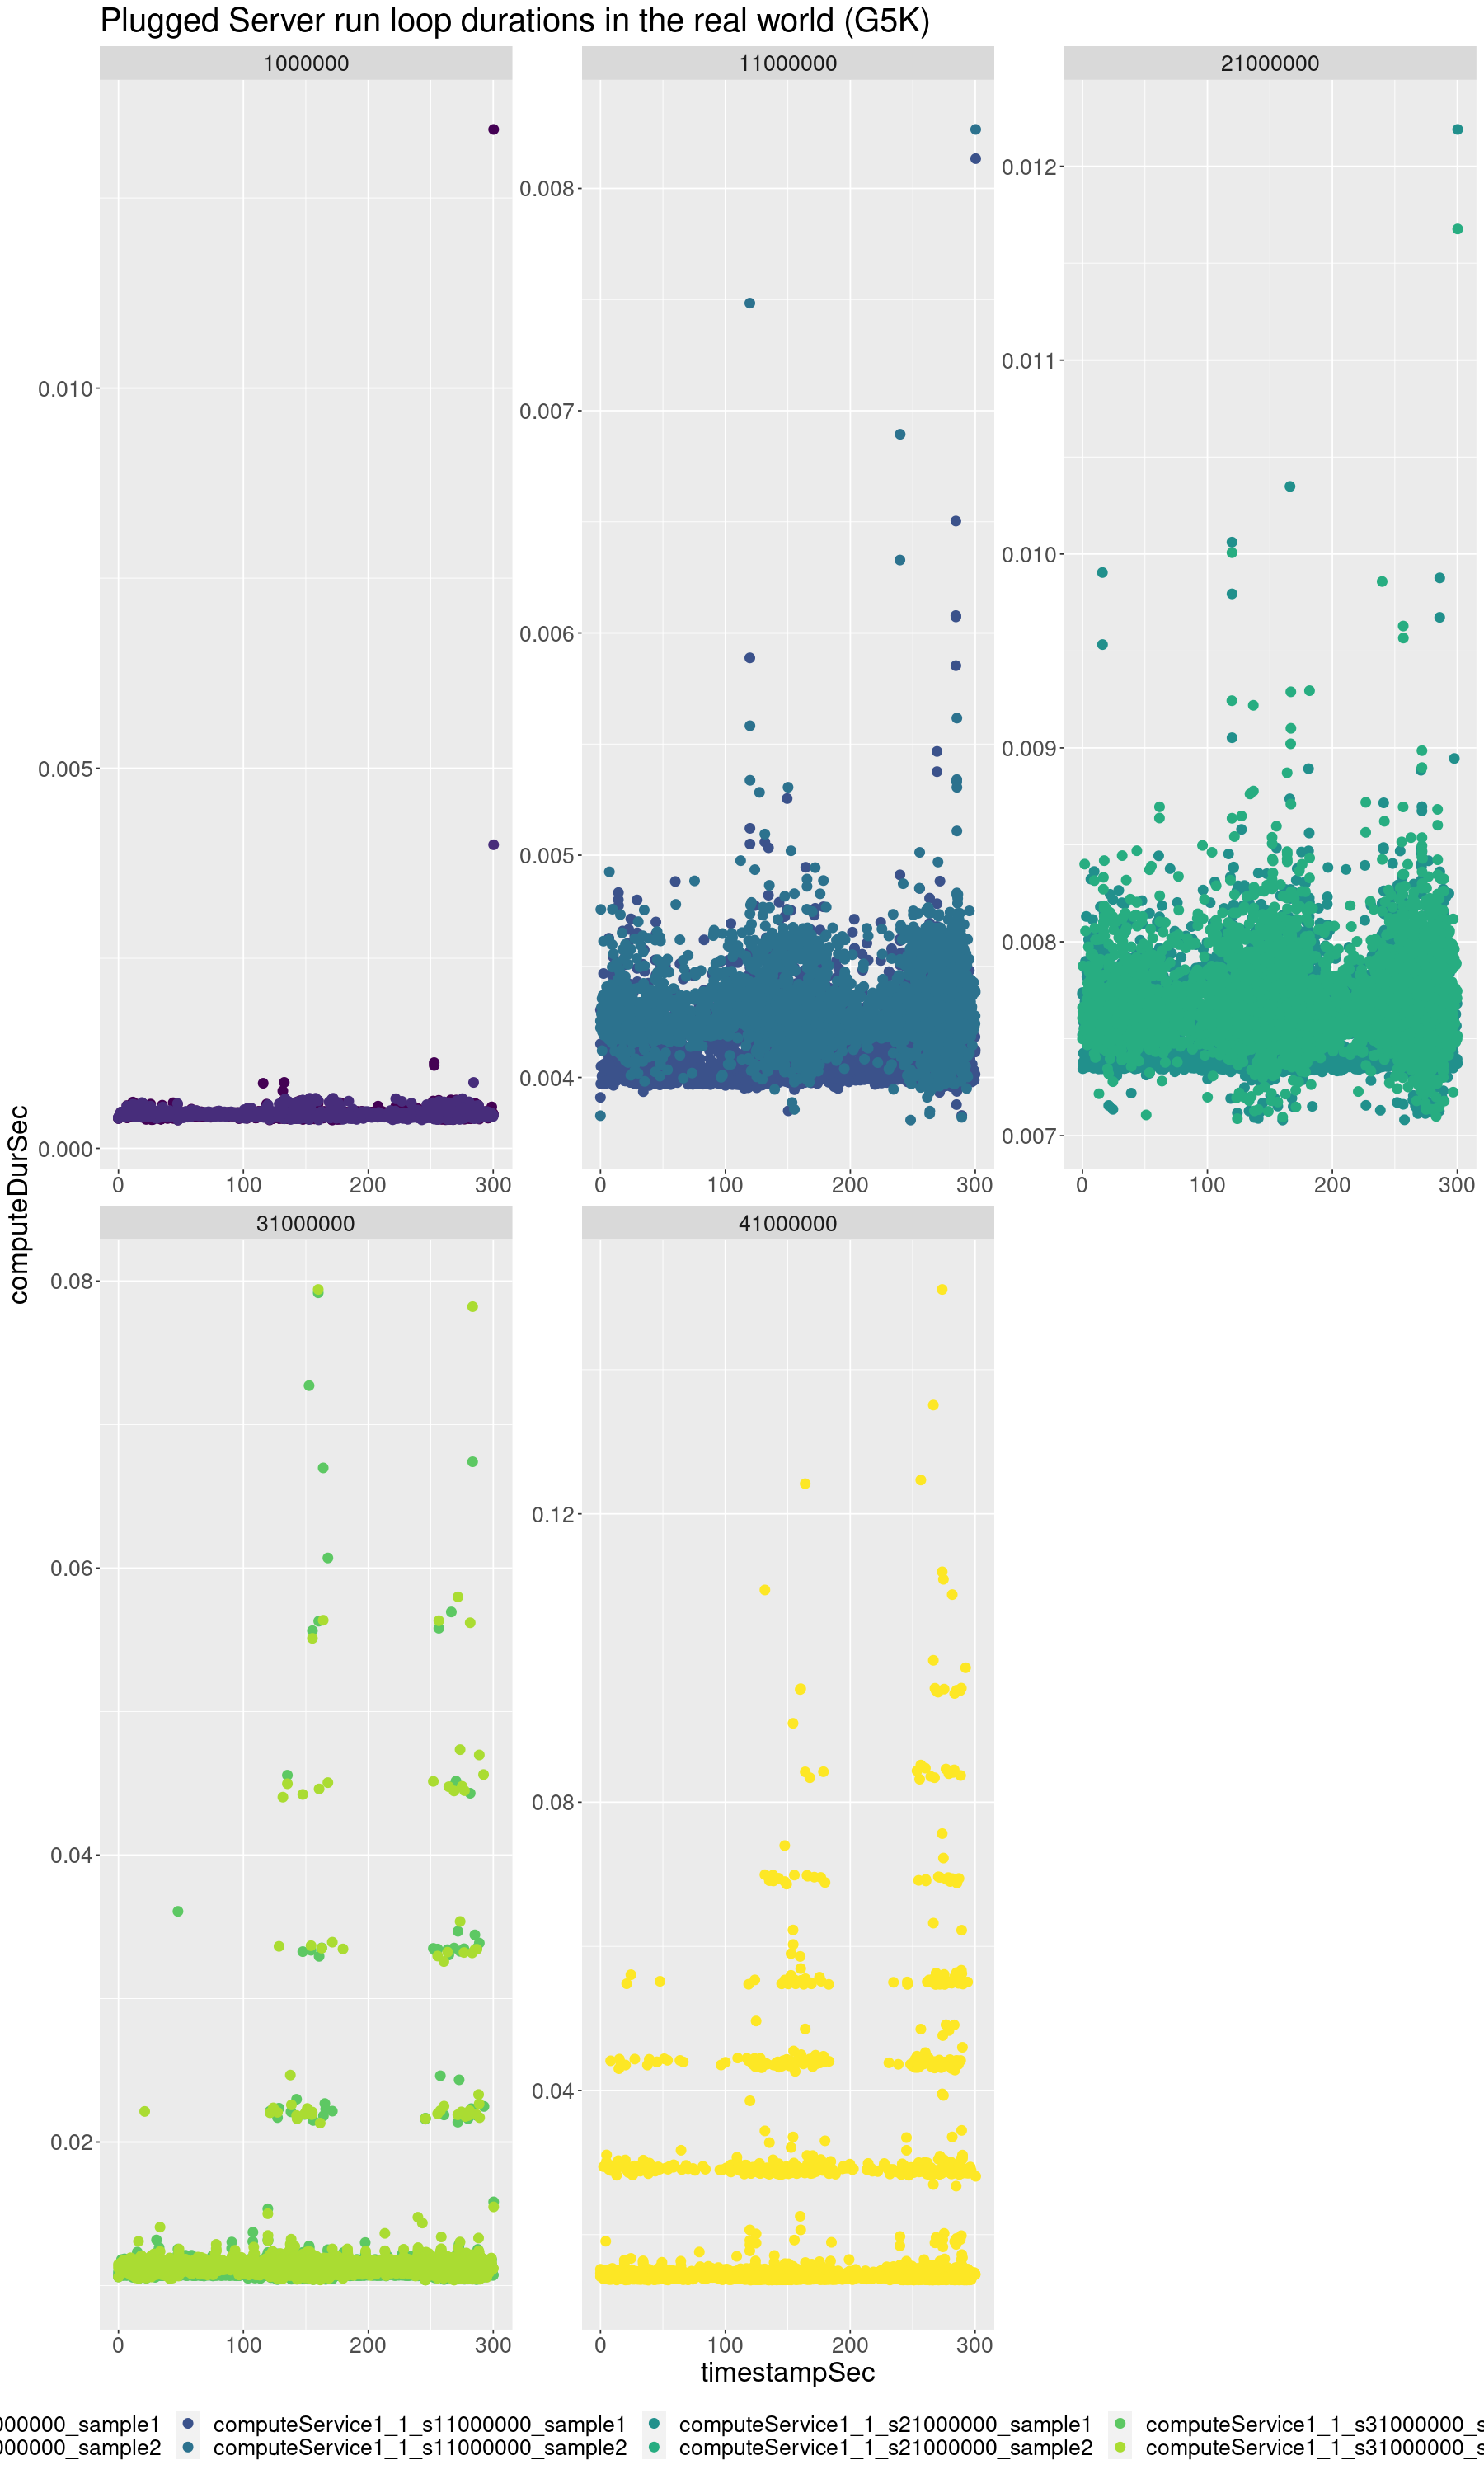

In [86]:
options(repr.plot.width=15, repr.plot.height=25)

data_RW_run_G5K <- as_tibble(read.csv("~/logs_expe/goLogs/g5klogs/g5krun/aggrResults_1000000-10000000-100000000_2.csv"))
data_RW_run_G5K$timestampSec <- as.numeric(as.character(data_RW_run_G5K$timestamp)) / 1e9
data_RW_run_G5K$computeDurSec <- as.numeric(as.character(data_RW_run_G5K$computeDur)) / 1e9
#head(data_loadRW_unplugged_953)
summary(data_RW_run_G5K)
#my_dataRW_1_compute <- my_dataRW_1 %>% filter(service == "compute")

ggplot(data_RW_run_G5K, aes(x=timestampSec, y=computeDurSec, colour=serviceName))+
    geom_point(size=3)+
    #geom_line(color="blue")+
    #geom_line(aes(y=rollmean(execDur, 50, na.pad=TRUE)), color="green", size=1.5)+
    ggtitle("Plugged Server run loop durations in the real world (G5K)")+
    facet_wrap("nbIter", scales="free")+
    theme( legend.position="bottom", text = element_text(size = 20)) + 
  scale_color_viridis(discrete = TRUE, option = "D")+
  scale_fill_viridis(discrete = TRUE) #+ geom_line(data = data_RW_run_G5K, aes(x=timestampSec, y=rollmean(computeDurSec, 100, na.pad=TRUE)), color="green", size=1.5)